Team 4

* Александр	Галанов	ag
* Владимир	Помелов	mel-po
* Павел	Мочалов	Pavel Mochalov
* Александр	Стальмаков	alex_st

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

try:
    from sklearn.model_selection import validation_curve
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.learning_curve import validation_curve
    from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import roc_auc_score

from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold
    from sklearn.cross_validation import train_test_split

In [2]:
#   _id - идентификатор человека
#   age - возраст
#   job - тип работы ("admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
#   marital - семейное положение ("divorced" (разведенный и овдовевший),"married","single","unknown")
#   education - уровень образования ("basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
#   default - есть ли дефолт по кредиту ("no","yes","unknown")
#   housing - есть ли кредит на жилье ("no","yes","unknown")
#   loan - есть ли персональный кредит ("no","yes","unknown")
#   contact - контактный тип связи ("cellular","telephone")
#   month - последний контактный месяц года ("jan", "feb", "mar", ..., "nov", "dec")
#   day_of_week - последний контактный день недели ("mon","tue","wed","thu","fri")
#   duration - длительность последнего контакта в секундах. (Важное замечание: этот атрибут сильно влияет на таргет (например, если длительность - 0 сек., то таргет - 0). Тем не менее, продолжительность не известна до выполнения вызова.
#   campaign - количество контактов, выполненных для этого клиента в рамках текущей маркетинговой кампании (включая последний контакт)
#   pdays - количество дней прошедших последнего контакта с клиентом с предыдущей маркетинговой кампании (999 означает, что ранее с клиентом не контактировали)
#   previous - количество контактов, выполненных до текущей маркетинговой кампании для этого клиента
#   poutcome - результат предыдущей маркетинговой кампании ("failure","nonexistent","success")
#   # ниже приведены показатели окружающей среды и банка
#   emp.var.rate - изменение уровня занятости (квартальный показатель)
#   cons.price.idx - индекс потребительских цен (ежемесячный показатель)
#   cons.conf.idx - индекс доверия потребителя (ежемесячный показатель)
#   euribor3m - курс Euribor (ежедневный показатель)
#   nr.employed - количество сотрудников (квартальный показатель)
#   target - целевая переменная (таргет) - согласился ли клиент на вклад (депозит)

In [3]:
df = pd.read_csv('train.csv', sep=',')
df.axes

[RangeIndex(start=0, stop=24712, step=1),
 Index(['_id', 'age', 'job', 'marital', 'education', 'default', 'housing',
        'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
        'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
        'cons.conf.idx', 'euribor3m', 'nr.employed', 'target'],
       dtype='object')]

In [4]:
df.info()
df.mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24712 entries, 0 to 24711
Data columns (total 22 columns):
_id               24712 non-null object
age               24712 non-null int64
job               24712 non-null object
marital           24712 non-null object
education         24712 non-null object
default           24712 non-null object
housing           24712 non-null object
loan              24712 non-null object
contact           24712 non-null object
month             24712 non-null object
day_of_week       24712 non-null object
duration          24712 non-null int64
campaign          24712 non-null int64
pdays             24712 non-null int64
previous          24712 non-null int64
poutcome          24712 non-null object
emp.var.rate      24712 non-null float64
cons.price.idx    24712 non-null float64
cons.conf.idx     24712 non-null float64
euribor3m         24712 non-null float64
nr.employed       24712 non-null float64
target            24712 non-null int64
dtypes: floa

age                 40.030188
duration           258.345298
campaign             2.580163
pdays              963.558797
previous             0.171900
emp.var.rate         0.082713
cons.price.idx      93.576386
cons.conf.idx      -40.516077
euribor3m            3.619397
nr.employed       5166.988111
target               0.112779
dtype: float64

In [5]:
def preproc(df_init):
    """
    какие бы комбинации кодирования данных не пробовал заметного улучшения модели не получил,
    оставил последний вариант как есть
    """ 
    df_preproc = df_init.copy()
    
    #dummy_columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']
    #bins = [16, 20, 65, 99]
    #df_preproc['age_cat'] = pd.cut(df_preproc.age, bins=bins)
    #bins_dur = [-1]# 60*2, 60*3, 60*4, 60*5, 60*6, 600, 900, 1000, 2000, 9999]
    #for i in range(1, 61, 10):
    #    bins_dur.append(i*60)
    #bins_dur.append(9999)
    ##df.groupby(['target',pd.cut(df.duration, bins=bins_dur)]).count()[['_id']].unstack(fill_value=0)['_id'] 
    #df_preproc['dur_cat'] = pd.cut(df_preproc.duration, bins=bins_dur)
    #
    #dummy_columns = ['age_cat', 'dur_cat', 'job', 'marital', 'education', 'contact', 'month', 'day_of_week']
    dummy_columns = ['marital', 'contact']#, 'month', 'day_of_week']
    #dummy_columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week']
    df_preproc = pd.get_dummies(df_preproc, columns=dummy_columns)
    
    TARGET_DF = df_preproc['target']
    df_preproc = df_preproc.drop(['_id'
    #                              , 'age'
    #                              , 'duration'
                                #  , 'job'
                                #  , 'marital'
                                #  , 'education'
                                # # , 'default'
                                # # , 'housing'
                                # # , 'loan'
                                #  , 'contact'
                                  , 'month'
                                  , 'day_of_week'
                                #  , 'poutcome'
                                  , 'target'
                                 ], axis=1)
    
    # Замена категориальных признаков
    df_preproc.loc[:, ['default', 'housing', 'loan']] = \
    df_preproc.loc[:, ['default', 'housing', 'loan']].replace({"no": 0
                                                               ,"yes": 1
                                                               ,"unknown": 0.5})
    for i in ['default', 'housing', 'loan']:
        df_preproc.loc[df_preproc[i] == 0.5, [i]] = df_preproc.loc[(df_preproc['loan'] != 0.5), 'loan'].mean()
    
    # 999 == ранне не контактировали
    df_preproc.loc[:, ['pdays']] = \
    df_preproc.loc[:, ['pdays']].replace({999: -1}) 
    
    df_preproc.loc[:, ['poutcome']] = \
    df_preproc.loc[:, ['poutcome']].replace({"failure": -1, "success": 1, "nonexistent": 0})
    
    # градация субъективно логичная, изменений не привнесла
    df_preproc.loc[:, ['education']] = \
    df_preproc.loc[:, ['education']].replace({
        "basic.4y":1
        ,"basic.6y":1
        ,"basic.9y":1
        ,"high.school":2
        ,"illiterate":0
        ,"professional.course":3
        ,"university.degree":4
        ,"unknown": -1
    })
    
    # работу по сути делю на 3 категории: работает, не работает, неизвестно
    df_preproc.loc[:, ['job']] = \
    df_preproc.loc[:, ['job']].replace({"admin.": 1
                                        ,"blue-collar":1
                                        ,"entrepreneur":1
                                        ,"housemaid":1
                                        ,"management":1
                                        ,"retired":0
                                        ,"self-employed":1
                                        ,"services" :1  
                                        ,"student":1
                                        ,"technician":1
                                        ,"unemployed":0
                                        ,"unknown":-1
        })
    
    
    return df_preproc, TARGET_DF

In [6]:
df_preproc, target_df = df.pipe(preproc)
# никому нельзя верять, даже себе, поэтому перед кроссвалидацией раздею выборку на 2
# чтобы потом ещё разок себя перепроверить
X, X_test, y, y_test = train_test_split(df_preproc.values, target_df, test_size=0.1, random_state=123)

### сына вырастил, дом построил, пора и дерево строить
### расти DecisionTreeClassifier большой и маленький

In [7]:
model = DecisionTreeClassifier(random_state=123)

# FIXME какое n_splits оптимально? Беру 30. Почему 30? Просто потому что могу
cv = StratifiedKFold(n_splits=30, shuffle=True, random_state=132)
train_scores, valid_scores = validation_curve(model, X, y, 
                                              'max_depth', range(1, 12),
                                              cv=cv, scoring='roc_auc')

Text(0,0.5,'ROC AUC')

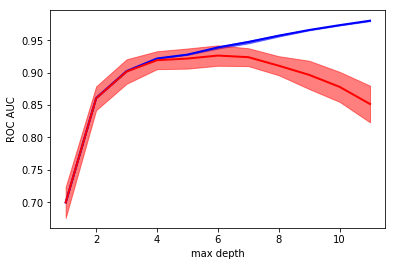

In [8]:
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,12), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,12), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,12), train_score_mean, c='b', lw=2)
plt.plot(range(1,12), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

In [9]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(4, 9),
    'min_samples_leaf': range(5, 15),
    'class_weight': [None, 'balanced']}

# FIXME не осилил английское описание как работает class_weight
# без max_depth и min_sapmles_leaf roc_auc совсем печальный
# как понял - именно этот параметр надо теребонькать когда выборка не сбалансированная, как у нас

# разницы между GridSearchCV и RandomizedSearchCV не заметил
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=-1,
                                   cv=cv, scoring='roc_auc')

grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=30, random_state=132, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(4, 9), 'min_samples_leaf': range(5, 15), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [10]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 14}

In [11]:
ra_dtc_train = grid_search.best_score_
ra_dtc_train

0.938430647067235

In [12]:
model = grid_search.best_estimator_
imp = model.feature_importances_

pd.Series(index=df_preproc.columns, data=imp).sort_values()
# внешние признаки в топе (duration не считая), как трактовать предупреждение о duration из описания не понял

loan                 0.000000
marital_unknown      0.000000
housing              0.000113
marital_divorced     0.000148
previous             0.000298
marital_married      0.000369
default              0.000518
marital_single       0.001189
job                  0.001353
contact_telephone    0.001543
contact_cellular     0.001759
education            0.002788
poutcome             0.003103
cons.price.idx       0.004269
age                  0.004356
campaign             0.005245
pdays                0.008401
cons.conf.idx        0.014441
euribor3m            0.086631
nr.employed          0.149041
emp.var.rate         0.212121
duration             0.502312
dtype: float64

In [13]:
TEST = model.predict(X_test)
model.score(X_test, y_test)

0.8280744336569579

In [14]:
ra_dtc_test = roc_auc_score(TEST, y_test)

In [15]:
print(classification_report(y_test, TEST))
# значение precision на класс 1 засталяет плакать
# в порядке бреда можно было бы как то выгрузить все FalseNegative строки выборки и поискать в них закономерности

             precision    recall  f1-score   support

          0       0.99      0.81      0.89      2202
          1       0.38      0.95      0.55       270

avg / total       0.93      0.83      0.86      2472



### Логистическая регрессия

In [16]:
# Определим пространство поиска

param_grid_log = {
    'C': randint(10, 18),
    'tol': [1e-4, 1e-5, 1e-3],
    'class_weight': [None, 'balanced']}

cv_log = StratifiedKFold(n_splits=15, random_state=123, shuffle=True)

model_log = LogisticRegression(random_state=123)
random_search = RandomizedSearchCV(model_log, param_distributions=param_grid_log, n_iter=20, n_jobs=-1,
                                   cv=cv_log, scoring='roc_auc', random_state=123)
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=15, random_state=123, shuffle=True),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115b63ba8>, 'tol': [0.0001, 1e-05, 0.001], 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [17]:
random_search.best_params_

{'C': 16, 'class_weight': 'balanced', 'tol': 1e-05}

In [18]:
model_log = random_search.best_estimator_
ra_log_train = random_search.best_score_
ra_log_train

0.928121894593177

In [19]:
TEST_log = model.predict(X_test)

model_log.score(X_test, y_test)

0.8596278317152104

In [20]:
ra_log_test = roc_auc_score(y_test, TEST_log)
ra_log_test
# не смотря на чуть худший показательна тренировочной выборке LogReg показывает себя заметно лучше на тестовой выборке

0.8823746089413664

In [21]:
print(classification_report(y_test, TEST_log))

             precision    recall  f1-score   support

          0       0.99      0.81      0.89      2202
          1       0.38      0.95      0.55       270

avg / total       0.93      0.83      0.86      2472



### KNN

In [22]:
model_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [23]:
model_knn.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [24]:
y_hat = model_knn.predict(X_test)
y_hat_proba = model_knn.predict_proba(X_test, )
y_hat_proba.shape

(2472, 2)

In [25]:
roc_auc_score(y_test, y_hat_proba[:, 1])

0.8766374003431224

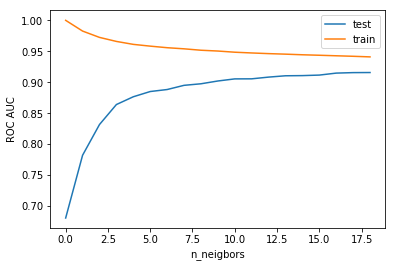

In [36]:
scores_test = []
scores_train = []

for k in range(1, 20):
    model_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    model_knn.fit(X, y)
    
    y_hat_test = model_knn.predict_proba(X_test)
    scores_test.append(roc_auc_score(y_test, y_hat_test[:, 1]))
    
    y_hat_train = model_knn.predict_proba(X)
    scores_train.append(roc_auc_score(y, y_hat_train[:, 1]))
    
    

plt.plot(scores_test, label='test')
plt.plot(scores_train, label='train')
plt.xlabel('n_neigbors')
plt.ylabel('ROC AUC')
plt.legend()

In [28]:
param_grid_knn = {
    'n_neighbors': randint(3, 20),
    'weights': ['uniform', 'distance']
    }

# Будем делать 20 запусков поиска
cv_knn = StratifiedKFold(n_splits=6, random_state=123, shuffle=True)

model_knn = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(model_knn, param_distributions=param_grid_knn, n_iter=20, n_jobs=-1,
                                   cv=cv_knn, scoring='roc_auc', random_state=123)
random_search_knn.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=6, random_state=123, shuffle=True),
          error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x116476fd0>, 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [29]:
random_search_knn.best_params_

{'n_neighbors': 19, 'weights': 'uniform'}

In [30]:
ra_knn_train = random_search_knn.best_score_
ra_knn_train

0.9152043729595161

In [31]:
best_model_knn = random_search_knn.best_estimator_

In [32]:
TEST_knn = best_model_knn.predict(X_test)
ra_knn_test = roc_auc_score(y_test, TEST_knn)
ra_knn_test

0.7545110505600968

In [33]:
best_model_knn.score(X_test, y_test)

0.9186893203883495

In [34]:
print(classification_report(y_test, TEST_knn))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95      2202
          1       0.65      0.54      0.59       270

avg / total       0.91      0.92      0.92      2472



### Итого

In [39]:
pd.DataFrame({'train': [ra_dtc_train, ra_log_train, ra_knn_train],
              'test': [ra_dtc_test, ra_log_test, ra_knn_test]}, index=pd.Index(['dtc', 'LogReg', 'KNN']))

,train,test
dtc,0.938431,0.688473
LogReg,0.928122,0.882375
KNN,0.915204,0.754511


значения в таблице выше +- пляшут, но тендеция вырисовывается однозначная
логистическая регрессия предположительно покажет лучший результат на тестовых данных 

In [45]:
df_test = pd.read_csv('test.csv', sep=',')
sub_res = pd.read_csv('sample_submission.csv')

In [47]:
df_test.head()

,_id,age,job,marital,education,default,housing,loan,contact,month,...,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,66810d8e6bf2b41c880a7bc6c8a1e295,57,technician,married,high.school,no,no,yes,cellular,may,...,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1
1,ccac3879652b08cb8b44c1920fd93afa,55,unknown,married,unknown,unknown,yes,no,telephone,may,...,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
2,fcccab4d7a76f70647f015f2c84c2af8,33,blue-collar,married,basic.9y,no,no,no,cellular,may,...,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1
3,ed8399278c30678dab739045fa12b440,36,admin.,married,high.school,no,no,no,telephone,jun,...,355,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
4,1d4d62ac5cabcb48bac7112813f290cb,27,housemaid,married,high.school,no,yes,no,cellular,jul,...,189,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1


In [50]:
sub_res.head()

,_id,target
0,66810d8e6bf2b41c880a7bc6c8a1e295,0
1,ccac3879652b08cb8b44c1920fd93afa,0
2,fcccab4d7a76f70647f015f2c84c2af8,0
3,ed8399278c30678dab739045fa12b440,0
4,1d4d62ac5cabcb48bac7112813f290cb,0


In [51]:
model_log

LogisticRegression(C=16, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False)

In [61]:
df_test.loc[:, 'target'] = 0 ### теперь я понял что не надо было добавлять в preproc разделение не данные и цель
df_test_preproc, _ = df_test.pipe(preproc)
df_test_preproc.head()

array([[54.,  0.,  2., ...,  0.,  1.,  0.],
       [37.,  1.,  2., ...,  0.,  1.,  0.],
       [31.,  1.,  4., ...,  0.,  1.,  0.],
       ...,
       [47.,  1.,  1., ...,  0.,  1.,  0.],
       [48.,  1.,  1., ...,  0.,  0.,  1.],
       [23.,  1.,  1., ...,  0.,  1.,  0.]])

In [64]:
result = model_log.predict(df_test_preproc)

In [68]:
p = 0
n = 0
for i in result:
    if i == 0:
        n+=1
    else:
        p+=1
        
print(p, n)

3749 12727


In [71]:
sub_res.loc[:, 'target'] = result

In [73]:
sub_res.describe()

,target
count,16476.000000
mean,0.227543
std,0.419259
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [75]:
df[['target']].describe()

,target
count,24712.000000
mean,0.112779
std,0.316329
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [78]:
sub_res.to_csv('sample_submission.csv', sep=',', index=False)

ловитесь данные, большие и маленькие